In [1]:
%load_ext lab_black

In [2]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger

import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from include.generators import Generator
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver


setMatplotlibParam()
plt.viridis()

2023-12-11 12:41:49.160309: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 12:41:49.201520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 12:41:49.201550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 12:41:49.201571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 12:41:49.208656: I tensorflow/core/platform/cpu_feature_g

<Figure size 1920x1440 with 0 Axes>

# Classic eval

### Model

In [3]:
dir_res = "/libre/dumontj/coco2/weights"
name_model = os.path.join(dir_res, "new/inv_lip")
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [4]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2023-12-09 13:54:34.292984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Train data

In [61]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_train_nc, model
)

In [6]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

2023-12-07 15:56:24.818810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-07 15:56:25.385585: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


786/786 [==============================] - 6s 5ms/step
mae: 14.074817
mape: 159.87793


### Valid data

In [60]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_nc, model
)

In [8]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 5ms/step
mae: 14.418165
mape: 163.9618


### Extra_valid data

In [9]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc, model
)

In [10]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 5ms/step
mae: 17.085978
mape: 118.7301


## Plot data

36/36 [==============================] - 0s 5ms/step


<Figure size 1920x1440 with 0 Axes>

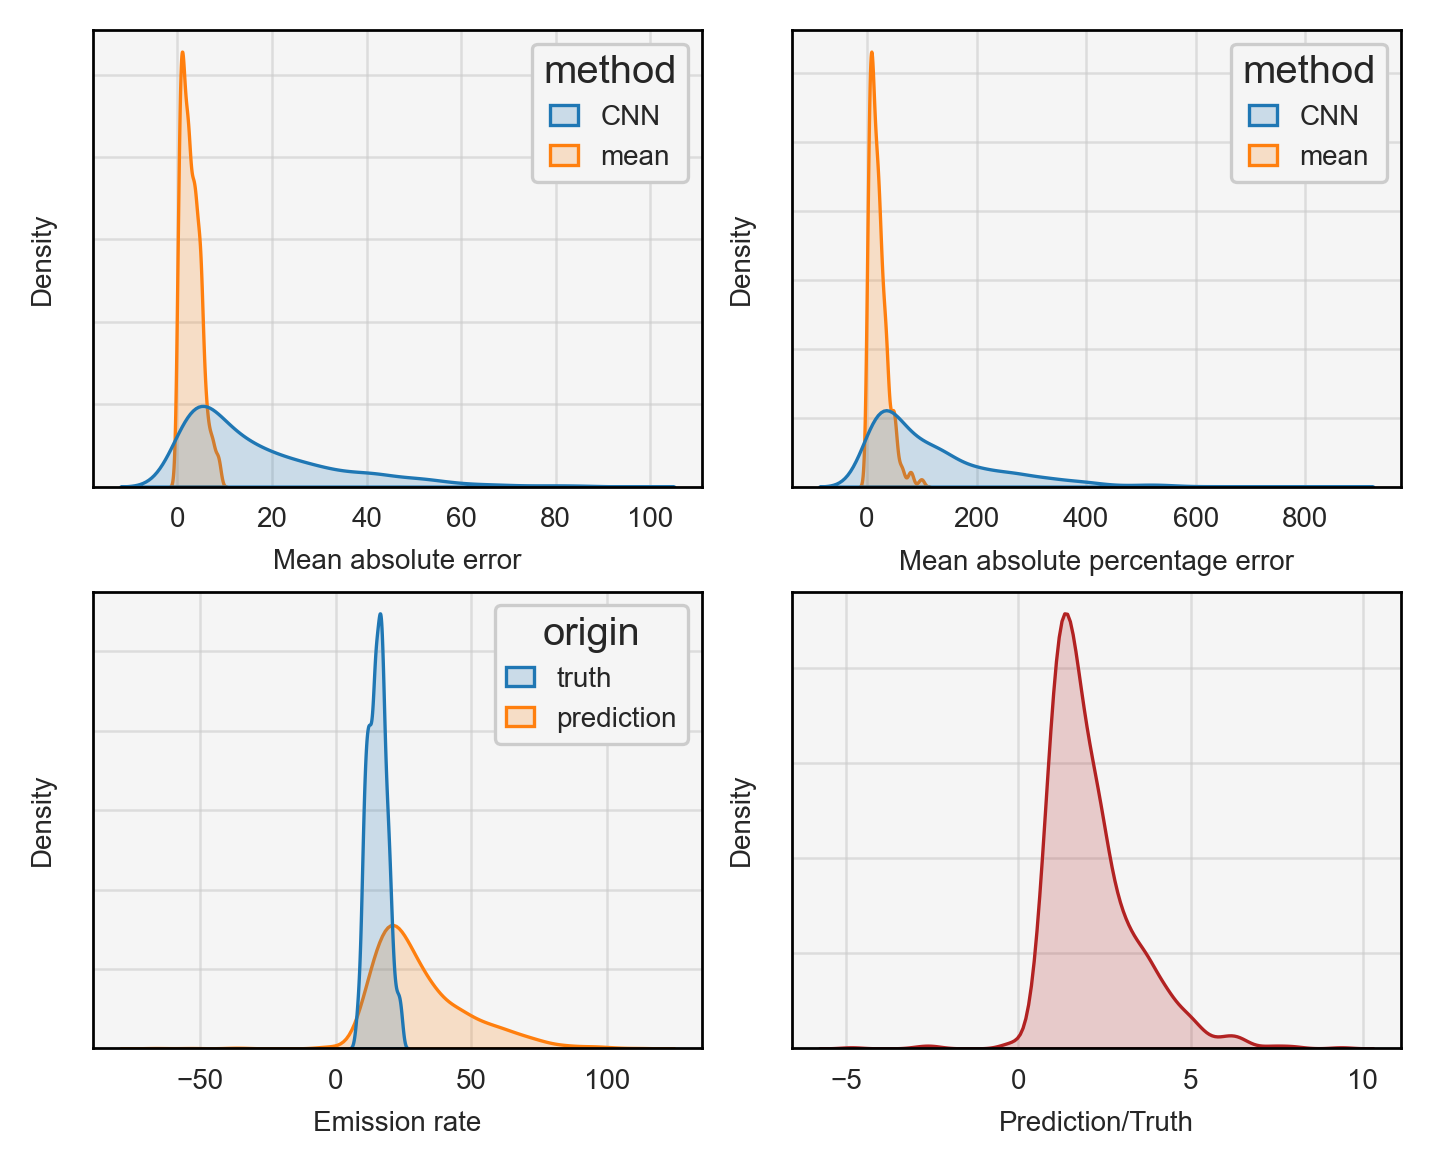

In [18]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: tf.Tensor(1.4076939, shape=(), dtype=float32)
idx 210
origin: smart_2km_Lip_64
time: 2015-03-06T18:00:00.000000000
emiss: [17.56142 18.57548 19.25024]
nwbce: tf.Tensor(2.9893913, shape=(), dtype=float32)
idx 196
origin: smart_2km_Lip_64
time: 2015-03-06T04:00:00.000000000
emiss: [12.49489 12.15679 13.33856]
nwbce: tf.Tensor(13.575432, shape=(), dtype=float32)
idx 65
origin: smart_2km_Lip_64
time: 2015-01-21T17:00:00.000000000
emiss: [21.14826 22.33432 22.72907]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

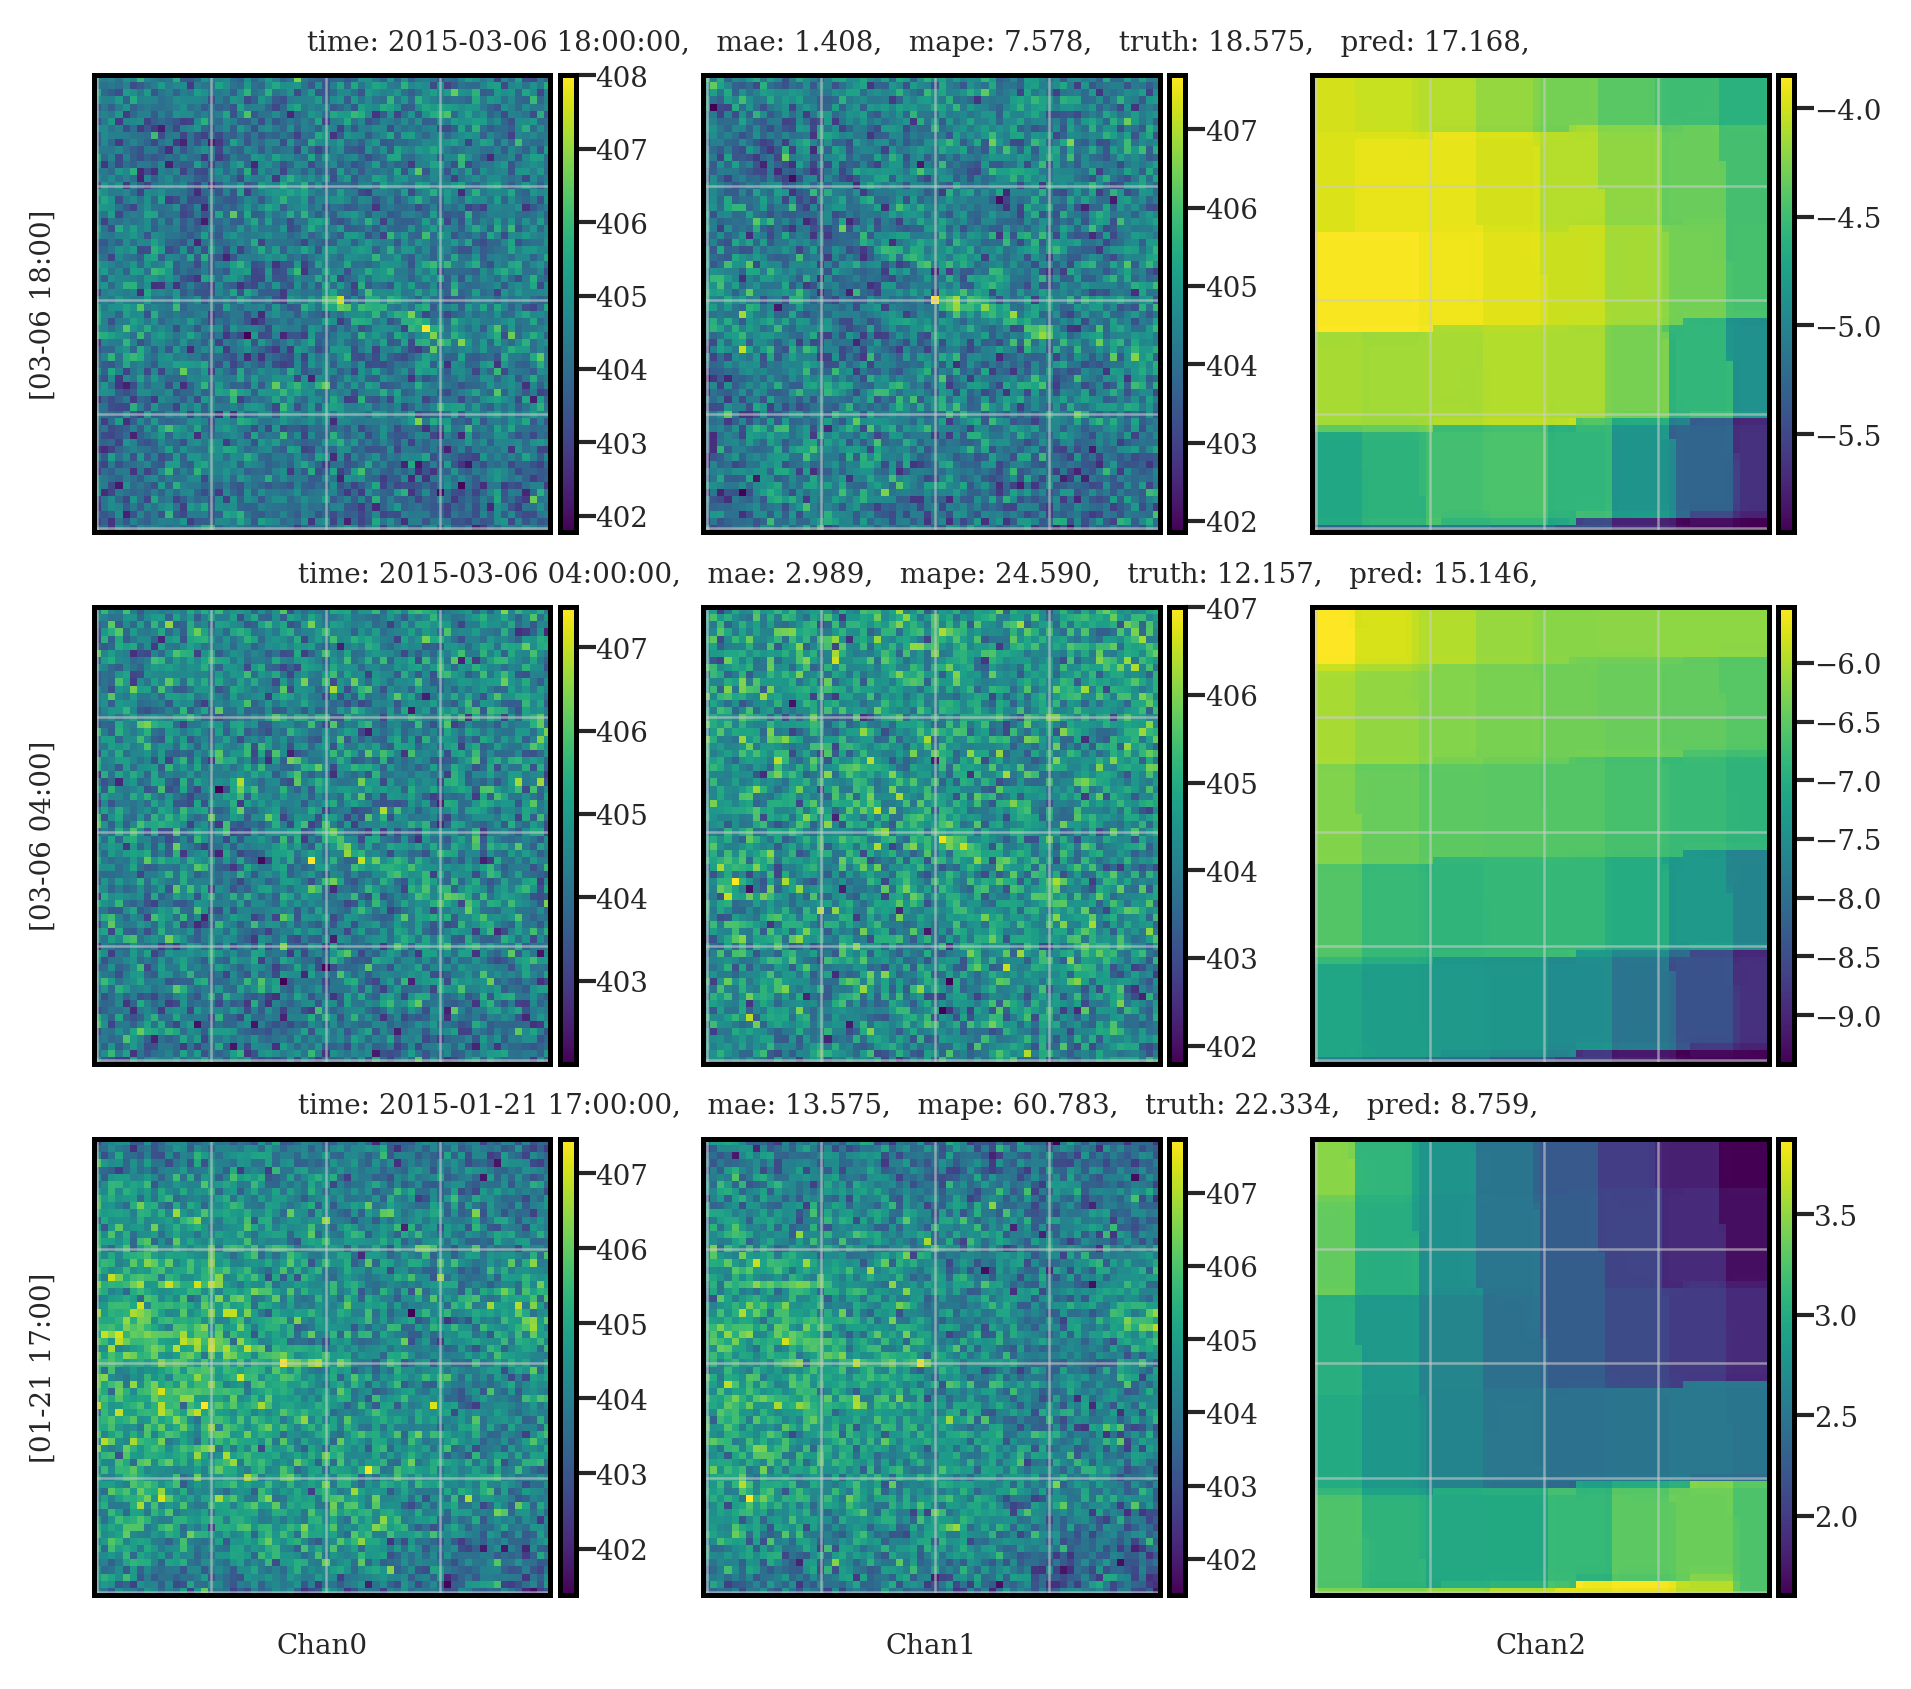

In [23]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)

In [38]:
num_examples = 5
example_indices = np.random.choice(data.x.eval.shape[0], num_examples, replace=False)

In [39]:
plot_data = data.x.eval

ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1869
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1263
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1320
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1423
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1873
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257


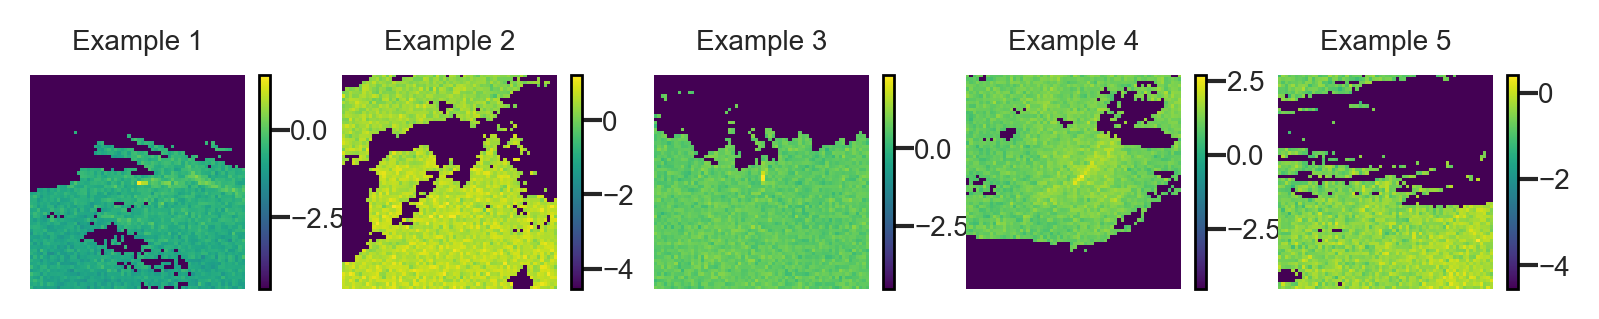

In [40]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

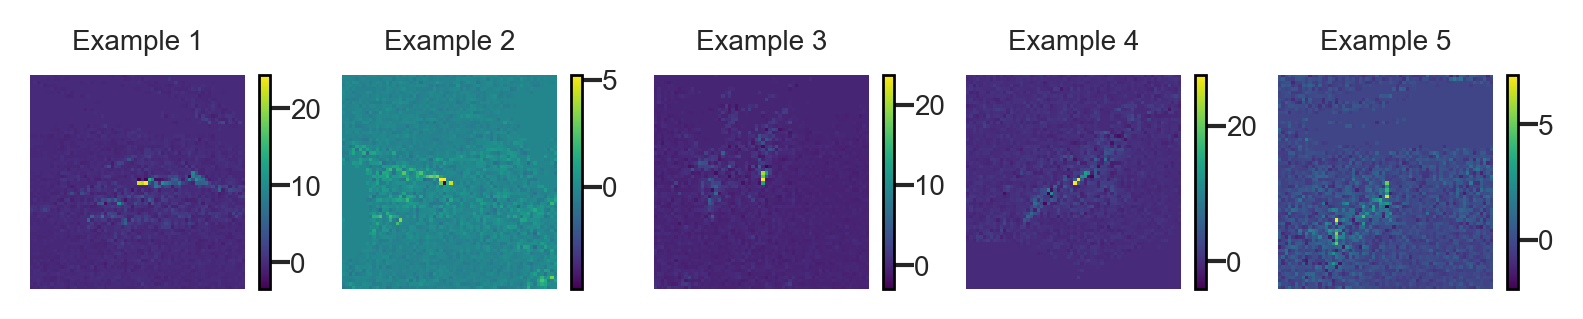

In [42]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [49]:
difference = np.any(np.not_equal(data.x.eval, preproc_layer(data.x.eval)))

# Study of loss difference at training and at evaluation

## Expériences avec nuages

### Prepare model, data, preproc_layer

In [11]:
cfg = compose(
    config_name="config",
    overrides=[
        "training.max_epochs=10",
        "+experiment=inv_lip",
        "data.path.train.nc=valid_dataset.nc",
    ],
)
data_valid_as_train = instantiate(cfg.data.init)

data_valid_as_train.prepare_input(
    cfg.data.input.chan_0,
    cfg.data.input.chan_1,
    cfg.data.input.chan_2,
    cfg.data.input.chan_3,
    cfg.data.input.chan_4,
    cfg.data.input.cloud_bool,
    cfg.data.input.path_clouds_array,
    cfg.data.input.dir_seg_models,
)
data_valid_as_train.prepare_output_inversion(cfg.data.output.N_emissions)

ic| self.train.shape: (4608, 64, 64, 4)


In [7]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

In [8]:
initiate_wb(cfg)

wandb: Currently logged in as: joffreydumont (cerea-daml). Use `wandb login --relogin` to force relogin


In [9]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [10]:
model = model_trainer.model
data = model_trainer.data
preproc_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("cloud_layer").output
)

mmap = np.load(data.x.path_clouds_array, mmap_mode="r")
clouds_training = np.array(mmap[: data.ds_train.N_img])
cloud_layer = preproc_layer.get_layer("cloud_layer")
cloud_layer.clouds_array = clouds_training

preproc_data_train = preproc_layer(data.x.train, training=True)
preproc_data_valid_as_train = preproc_layer(data_valid_as_train.x.train, training=True)

### Plot

In [ ]:

plot_data = preproc_data_train

In [54]:
num_examples = 5
example_indices = np.random.choice(data.x.train.shape[0], num_examples, replace=False)

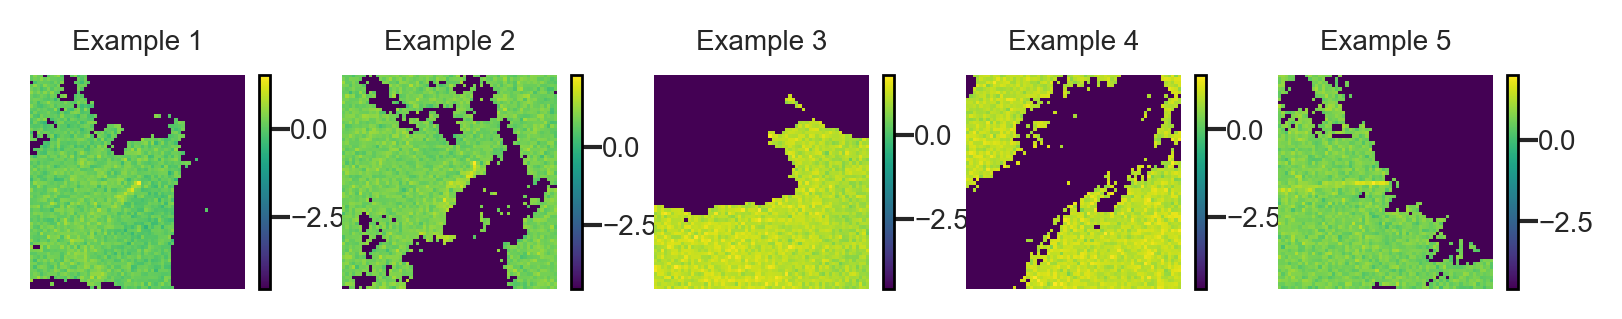

In [55]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [60]:
plot_data = data.x.extra_valid

In [61]:
num_examples = 5
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

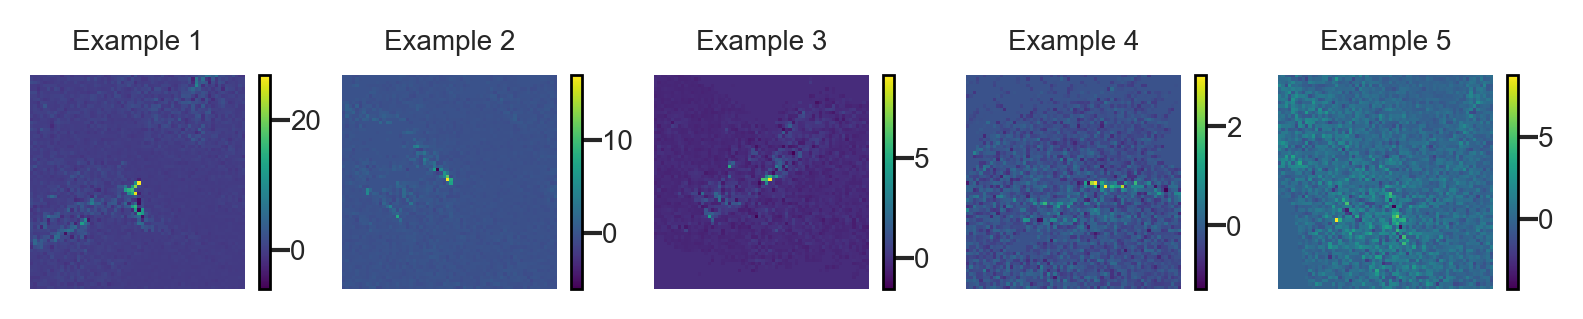

In [62]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

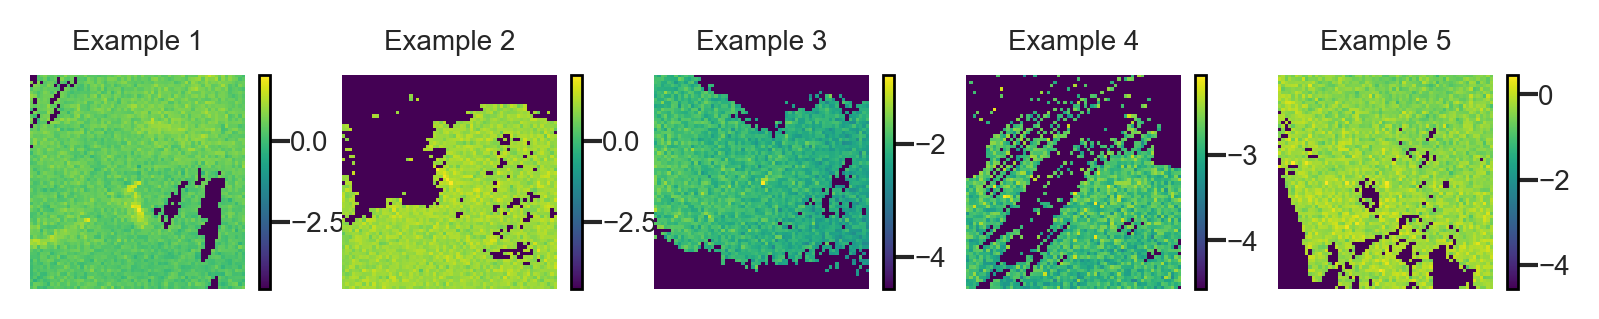

In [63]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

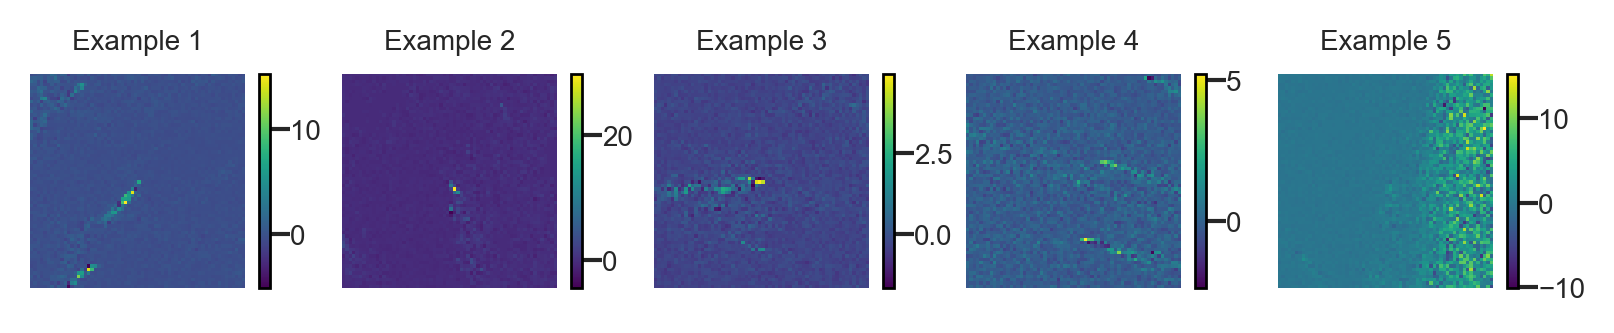

In [18]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### Results blank model

In [20]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 8ms/step
mae: 13.076509
mape: 96.482635


In [22]:
model.fit(data.x.train, data.y.train)

786/786 [==============================] - 29s 35ms/step - loss: 3.8979 - mean_absolute_percentage_error: 31.0934 - mean_absolute_error: 3.8979


In [ ]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 6s 8ms/step
mae: 2.9825795
mape: 24.57008


In [27]:
pred = model_trainer.model(data.x.train, training=True)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.0215447
mape: 25.717232


### Results after training without generator

In [32]:
model.fit(
            data.x.train, data.y.train,
            epochs=model_trainer.trainer.N_epochs,
            validation_data=(data.x.valid, data.y.valid),
            verbose=1,
            steps_per_epoch=int(np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)),
            callbacks=model_trainer.trainer.callbacks,
            shuffle=True,
        )


Epoch 1/10
 69/786 [=>............................] - ETA: 26s - loss: 2.2115 - mean_absolute_percentage_error: 17.7106 - mean_absolute_error: 2.2115

KeyboardInterrupt: 

In [33]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 2.4419527
mape: 17.909014


In [36]:
pred = tf.convert_to_tensor(model.predict(preproc_data_eval), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 7.214764
mape: 45.52759


### Results after training with generator (isolation du generator)

In [95]:
model.fit(
    model_trainer.trainer.generator,
    epochs=20,
    validation_data=(data.x.valid, data.y.valid),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

Epoch 1/20
785/786 [============================>.] - ETA: 0s - loss: 6.4536 - mean_absolute_percentage_error: 48.4577 - mean_absolute_error: 6.4536
Epoch 1: val_loss did not improve from 9.42286
extra_val_loss: [8.415576934814453, 59.91614532470703, 8.415576934814453]
786/786 [==============================] - 30s 39ms/step - loss: 6.4523 - mean_absolute_percentage_error: 48.4458 - mean_absolute_error: 6.4523 - val_loss: 9.7014 - val_mean_absolute_percentage_error: 107.3278 - val_mean_absolute_error: 9.7014 - lr: 0.0010
Epoch 2/20
785/786 [============================>.] - ETA: 0s - loss: 6.4379 - mean_absolute_percentage_error: 47.2072 - mean_absolute_error: 6.4379
Epoch 2: val_loss did not improve from 9.42286
extra_val_loss: [13.75675106048584, 96.20465850830078, 13.75675106048584]
786/786 [==============================] - 30s 39ms/step - loss: 6.4378 - mean_absolute_percentage_error: 47.2071 - mean_absolute_error: 6.4378 - val_loss: 12.9944 - val_mean_absolute_percentage_error: 1

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_125138-bya2y9yr/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_125138-bya2y9yr/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_125138-bya2y9yr/files/model-best)... Done. 0.1s


extra_val_loss: [7.779414653778076, 54.52561950683594, 7.779414653778076]
786/786 [==============================] - 33s 41ms/step - loss: 5.9331 - mean_absolute_percentage_error: 43.6293 - mean_absolute_error: 5.9331 - val_loss: 8.2600 - val_mean_absolute_percentage_error: 92.1400 - val_mean_absolute_error: 8.2600 - lr: 0.0010
Epoch 11/20
785/786 [============================>.] - ETA: 0s - loss: 5.9398 - mean_absolute_percentage_error: 44.0565 - mean_absolute_error: 5.9398
Epoch 11: val_loss did not improve from 8.25997
extra_val_loss: [8.290809631347656, 58.1881103515625, 8.290809631347656]
786/786 [==============================] - 31s 39ms/step - loss: 5.9390 - mean_absolute_percentage_error: 44.0433 - mean_absolute_error: 5.9390 - val_loss: 8.6222 - val_mean_absolute_percentage_error: 94.7052 - val_mean_absolute_error: 8.6222 - lr: 0.0010
Epoch 12/20
785/786 [============================>.] - ETA: 0s - loss: 5.8801 - mean_absolute_percentage_error: 43.1701 - mean_absolute_error: 

In [96]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 8.532995
mape: 94.02738


In [97]:
pred = tf.convert_to_tensor(model.predict(data.x.valid), np.float32)
y = tf.convert_to_tensor(data.y.valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 10ms/step
mae: 8.440571
mape: 93.27361


In [98]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 7.0448623
mape: 49.354614


In [99]:
pred = tf.convert_to_tensor(model.predict(preproc_data_valid_as_train), np.float32)
y = tf.convert_to_tensor(data_valid_as_train.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 9ms/step
mae: 8.248276
mape: 90.94367


In [100]:
num_samples = 1000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
preproc_collected_samples = preproc_layer(collected_samples, training=True)

In [101]:
pred = tf.convert_to_tensor(model.predict(preproc_collected_samples), np.float32)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

32/32 [==============================] - 0s 10ms/step
mae: 9.68
mape: 90.8191


In [102]:
model.fit(
    model_trainer.trainer.generator,
    epochs=1,
    validation_data=(preproc_collected_samples, collected_outputs),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

785/786 [============================>.] - ETA: 0s - loss: 5.6558 - mean_absolute_percentage_error: 41.1962 - mean_absolute_error: 5.6558
Epoch 1: val_loss did not improve from 8.25997
extra_val_loss: [7.7225799560546875, 54.123104095458984, 7.7225799560546875]
786/786 [==============================] - 29s 37ms/step - loss: 5.6574 - mean_absolute_percentage_error: 41.2046 - mean_absolute_error: 5.6574 - val_loss: 9.1930 - val_mean_absolute_percentage_error: 88.3867 - val_mean_absolute_error: 9.2126 - lr: 0.0010


In [103]:
num_samples = 10000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
preproc_collected_samples = preproc_layer(collected_samples, training=True)

In [104]:
pred = tf.convert_to_tensor(model.predict(preproc_collected_samples), np.float32)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 9.225541
mape: 92.843956


In [105]:
model.fit(
    collected_samples,
    collected_outputs,
    epochs=1,
    validation_data=(preproc_collected_samples, collected_outputs),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

770/786 [============================>.] - ETA: 0s - loss: 6.1737 - mean_absolute_percentage_error: 44.3808 - mean_absolute_error: 6.1712WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 786 batches). You may need to use the repeat() function when building your dataset.



Epoch 1: val_loss did not improve from 8.25997
extra_val_loss: [8.279491424560547, 57.98263931274414, 8.279491424560547]
786/786 [==============================] - 20s 25ms/step - loss: 6.1737 - mean_absolute_percentage_error: 44.3808 - mean_absolute_error: 6.1712 - val_loss: 10.4293 - val_mean_absolute_percentage_error: 102.3686 - val_mean_absolute_error: 10.4266 - lr: 0.0010


In [106]:
pred = tf.convert_to_tensor(model.predict(preproc_collected_samples), np.float32)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 10.42931
mape: 102.24497


### Results after training with generator scale = [0.5,1.5]

In [67]:
generator = ScaleDataGen(
    data.x.train,
    data.x.plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    data.y.train,
    data.x.scale_bool,
    data.x.fields_input_shape,
    plume_scaling_min=0.5,
    plume_scaling_max=1.5,
)

In [68]:
model.fit(
    generator,
    epochs=model_trainer.trainer.N_epochs,
    validation_data=(data.x.valid, data.y.valid),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

Epoch 1/10
785/786 [============================>.] - ETA: 0s - loss: 5.5665 - mean_absolute_percentage_error: 34.5414 - mean_absolute_error: 5.5665
Epoch 1: val_loss did not improve from 2.56470
extra_val_loss: [6.6851701736450195, 46.52200698852539, 6.6851701736450195]
786/786 [==============================] - 29s 37ms/step - loss: 5.5744 - mean_absolute_percentage_error: 34.5229 - mean_absolute_error: 5.5744 - val_loss: 7.8595 - val_mean_absolute_percentage_error: 86.9877 - val_mean_absolute_error: 7.8595 - lr: 0.0010
Epoch 2/10
785/786 [============================>.] - ETA: 0s - loss: 4.2684 - mean_absolute_percentage_error: 27.8516 - mean_absolute_error: 4.2684
Epoch 2: val_loss did not improve from 2.56470
extra_val_loss: [7.897782325744629, 55.8754768371582, 7.897782325744629]
786/786 [==============================] - 30s 38ms/step - loss: 4.2679 - mean_absolute_percentage_error: 27.8465 - mean_absolute_error: 4.2679 - val_loss: 9.1915 - val_mean_absolute_percentage_error: 10

In [69]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 8ms/step
mae: 8.689793
mape: 99.28812


In [70]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 7.702595
mape: 54.184437


### Results after training with custom generator scale = [1,1]

In [72]:
generator = ScaleDataGen(
    data.x.train,
    data.x.plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    data.y.train,
    data.x.scale_bool,
    data.x.fields_input_shape,
    plume_scaling_min=1,
    plume_scaling_max=1,
)

In [73]:
model.fit(
    generator,
    epochs=model_trainer.trainer.N_epochs,
    validation_data=(data.x.valid, data.y.valid),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

Epoch 1/10
785/786 [============================>.] - ETA: 0s - loss: 4.5858 - mean_absolute_percentage_error: 25.7436 - mean_absolute_error: 4.5858
Epoch 1: val_loss did not improve from 2.56470
extra_val_loss: [3.642681121826172, 24.504249572753906, 3.642681121826172]
786/786 [==============================] - 28s 36ms/step - loss: 4.5835 - mean_absolute_percentage_error: 25.7364 - mean_absolute_error: 4.5835 - val_loss: 5.8269 - val_mean_absolute_percentage_error: 62.5022 - val_mean_absolute_error: 5.8269 - lr: 0.0010
Epoch 2/10
785/786 [============================>.] - ETA: 0s - loss: 3.4604 - mean_absolute_percentage_error: 19.8027 - mean_absolute_error: 3.4604
Epoch 2: val_loss did not improve from 2.56470
extra_val_loss: [4.995730876922607, 35.84544372558594, 4.995730876922607]
786/786 [==============================] - 28s 36ms/step - loss: 3.4606 - mean_absolute_percentage_error: 19.8092 - mean_absolute_error: 3.4606 - val_loss: 7.6744 - val_mean_absolute_percentage_error: 87

In [74]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 6s 8ms/step
mae: 6.1197095
mape: 68.13383


In [75]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 4.2833614
mape: 29.727112


In [77]:
pred = tf.convert_to_tensor(model.predict(data.x.valid), np.float32)
y = tf.convert_to_tensor(data.y.valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 9ms/step
mae: 6.286928
mape: 69.01702


### Sans NO2

In [29]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=[
        "training.max_epochs=10",
        "+experiment=inv_lip",
        "data.input.chan_3=None",
    ],
)

In [30]:
initiate_wb(cfg)

epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▄▃▂▂▂▂▁▁▁
epoch/mean_absolute_percentage_error,█▄▃▂▂▂▂▁▁▁
epoch/val_loss,█▃▂▄▅▂▁▂▂▂
epoch/val_mean_absolute_error,█▃▂▄▅▂▁▂▂▂
epoch/val_mean_absolute_percentage_error,█▃▂▄▅▂▁▂▂▂
extra_val_loss,█▂▃▂▃▂▂▁▂▂


In [31]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 3)


In [32]:
preproc_layer = tf.keras.models.Model(
    inputs=model_trainer.model.input,
    outputs=model_trainer.model.get_layer("norm_layer").output,
)

In [33]:
model = model_trainer.model
data = model_trainer.data
preproc_data_train = preproc_layer(data.x.train, training=True)

In [34]:
model.fit(model_trainer.trainer.train_model(model_trainer.model, model_trainer.data))

Epoch 1/10
785/786 [============================>.] - ETA: 0s - loss: 12.3157 - mean_absolute_percentage_error: 84.8568 - mean_absolute_error: 12.3157
Epoch 1: val_loss improved from inf to 9.45737, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_195031-1hf2qnq7/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_195031-1hf2qnq7/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_195031-1hf2qnq7/files/model-best)... Done. 0.1s


extra_val_loss: [8.063176155090332, 55.618003845214844, 8.063176155090332]
786/786 [==============================] - 36s 43ms/step - loss: 12.3059 - mean_absolute_percentage_error: 84.8201 - mean_absolute_error: 12.3059 - val_loss: 9.4574 - val_mean_absolute_percentage_error: 99.2660 - val_mean_absolute_error: 9.4574 - lr: 0.0010
Epoch 2/10
785/786 [============================>.] - ETA: 0s - loss: 8.9394 - mean_absolute_percentage_error: 63.2350 - mean_absolute_error: 8.9394
Epoch 2: val_loss did not improve from 9.45737
extra_val_loss: [15.594392776489258, 111.6540756225586, 15.594392776489258]
786/786 [==============================] - 33s 42ms/step - loss: 8.9377 - mean_absolute_percentage_error: 63.2391 - mean_absolute_error: 8.9377 - val_loss: 17.3956 - val_mean_absolute_percentage_error: 203.2094 - val_mean_absolute_error: 17.3956 - lr: 0.0010
Epoch 3/10
785/786 [============================>.] - ETA: 0s - loss: 8.0570 - mean_absolute_percentage_error: 57.0167 - mean_absolute_e

ValueError: Failed to find data adapter that can handle input: <class 'keras.src.engine.functional.Functional'>, <class 'NoneType'>

In [35]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 6.758524
mape: 71.82146


In [36]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 15.995514
mape: 114.55849


## Expériences sans nuages

### Avec NO2

In [62]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=[
        "training.max_epochs=10",
        "+experiment=inv_lip",
        "data.path.train.nc=valid_dataset.nc",
    ],
)

In [63]:
data_valid_as_train = instantiate(cfg.data.init)

data_valid_as_train.prepare_input(
    cfg.data.input.chan_0,
    cfg.data.input.chan_1,
    cfg.data.input.chan_2,
    cfg.data.input.chan_3,
    cfg.data.input.chan_4,
    cfg.data.input.cloud_bool,
    cfg.data.input.path_clouds_array,
    cfg.data.input.dir_seg_models,
)
data_valid_as_train.prepare_output_inversion(cfg.data.output.N_emissions)

ic| self.train.shape: (4608, 64, 64, 4)


In [49]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=[
        "training.max_epochs=10",
        "+experiment=inv_lip",
        "data.input.cloud_bool=False",
    ],
)

In [50]:
initiate_wb(cfg)

epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▂▂▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▆▅▄▃▂▂▁▁▁
epoch/mean_absolute_percentage_error,█▇▆▄▃▂▂▁▁▁
epoch/val_loss,▁▃▅▆█▆▅▃▅▄
epoch/val_mean_absolute_error,▁▃▅▆█▆▅▃▅▄
epoch/val_mean_absolute_percentage_error,▁▄▅▇█▆▆▃▅▄
extra_val_loss,▁▄▅██▇▇▅▇▇


In [51]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)


In [52]:
preproc_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("norm_layer").output
)

In [64]:
model = model_trainer.model
data = model_trainer.data
preproc_data_train = preproc_layer(data.x.train, training=True)
preproc_data_valid_as_train = preproc_layer(data_valid_as_train.x.train, training=True)

In [54]:
model.fit(model_trainer.trainer.train_model(model_trainer.model, model_trainer.data))

Epoch 1/10
786/786 [==============================] - ETA: 0s - loss: 12.6179 - mean_absolute_percentage_error: 91.9519 - mean_absolute_error: 12.6179
Epoch 1: val_loss improved from inf to 7.10812, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [3.009389877319336, 20.497068405151367, 3.009389877319336]
786/786 [==============================] - 36s 45ms/step - loss: 12.6179 - mean_absolute_percentage_error: 91.9519 - mean_absolute_error: 12.6179 - val_loss: 7.1081 - val_mean_absolute_percentage_error: 64.6071 - val_mean_absolute_error: 7.1081 - lr: 0.0010
Epoch 2/10
785/786 [============================>.] - ETA: 0s - loss: 9.0301 - mean_absolute_percentage_error: 66.6978 - mean_absolute_error: 9.0301
Epoch 2: val_loss improved from 7.10812 to 5.47559, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [5.187823295593262, 33.13541793823242, 5.187823295593262]
786/786 [==============================] - 33s 42ms/step - loss: 9.0330 - mean_absolute_percentage_error: 66.6744 - mean_absolute_error: 9.0330 - val_loss: 5.4756 - val_mean_absolute_percentage_error: 40.4449 - val_mean_absolute_error: 5.4756 - lr: 0.0010
Epoch 3/10
785/786 [============================>.] - ETA: 0s - loss: 7.1203 - mean_absolute_percentage_error: 50.0944 - mean_absolute_error: 7.1203
Epoch 3: val_loss improved from 5.47559 to 4.04682, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [3.974057197570801, 26.6151123046875, 3.974057197570801]
786/786 [==============================] - 32s 40ms/step - loss: 7.1183 - mean_absolute_percentage_error: 50.0732 - mean_absolute_error: 7.1183 - val_loss: 4.0468 - val_mean_absolute_percentage_error: 32.3089 - val_mean_absolute_error: 4.0468 - lr: 0.0010
Epoch 4/10
785/786 [============================>.] - ETA: 0s - loss: 6.4412 - mean_absolute_percentage_error: 45.9309 - mean_absolute_error: 6.4412
Epoch 4: val_loss improved from 4.04682 to 3.63716, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [4.51870059967041, 30.95026397705078, 4.51870059967041]
786/786 [==============================] - 31s 40ms/step - loss: 6.4423 - mean_absolute_percentage_error: 45.9148 - mean_absolute_error: 6.4423 - val_loss: 3.6372 - val_mean_absolute_percentage_error: 30.3279 - val_mean_absolute_error: 3.6372 - lr: 0.0010
Epoch 5/10
785/786 [============================>.] - ETA: 0s - loss: 6.1418 - mean_absolute_percentage_error: 43.1929 - mean_absolute_error: 6.1418
Epoch 5: val_loss did not improve from 3.63716
extra_val_loss: [3.9383621215820312, 25.532062530517578, 3.9383621215820312]
786/786 [==============================] - 28s 35ms/step - loss: 6.1435 - mean_absolute_percentage_error: 43.1877 - mean_absolute_error: 6.1435 - val_loss: 4.0267 - val_mean_absolute_percentage_error: 31.4270 - val_mean_absolute_error: 4.0267 - lr: 0.0010
Epoch 6/10
785/786 [============================>.] - ETA: 0s - loss: 5.8135 - mean_absolute_percentage_error: 40.6300 - mean_absolute_error: 5

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [3.88716459274292, 26.557941436767578, 3.88716459274292]
786/786 [==============================] - 31s 39ms/step - loss: 5.5582 - mean_absolute_percentage_error: 38.7188 - mean_absolute_error: 5.5582 - val_loss: 3.5876 - val_mean_absolute_percentage_error: 31.3738 - val_mean_absolute_error: 3.5876 - lr: 0.0010
Epoch 8/10
785/786 [============================>.] - ETA: 0s - loss: 5.4477 - mean_absolute_percentage_error: 37.7659 - mean_absolute_error: 5.4477
Epoch 8: val_loss improved from 3.58755 to 3.53744, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [3.8425512313842773, 26.585960388183594, 3.8425512313842773]
786/786 [==============================] - 31s 39ms/step - loss: 5.4473 - mean_absolute_percentage_error: 37.7597 - mean_absolute_error: 5.4473 - val_loss: 3.5374 - val_mean_absolute_percentage_error: 29.8299 - val_mean_absolute_error: 3.5374 - lr: 0.0010
Epoch 9/10
785/786 [============================>.] - ETA: 0s - loss: 5.2905 - mean_absolute_percentage_error: 36.5444 - mean_absolute_error: 5.2905
Epoch 9: val_loss did not improve from 3.53744
extra_val_loss: [3.8526976108551025, 26.860368728637695, 3.8526976108551025]
786/786 [==============================] - 32s 40ms/step - loss: 5.2899 - mean_absolute_percentage_error: 36.5485 - mean_absolute_error: 5.2899 - val_loss: 3.7505 - val_mean_absolute_percentage_error: 35.3433 - val_mean_absolute_error: 3.7505 - lr: 0.0010
Epoch 10/10
785/786 [============================>.] - ETA: 0s - loss: 5.2805 - mean_absolute_percentage_error: 36.9346 - mean_absolute_er

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231208_113034-3lzgv80n/files/model-best)... Done. 0.1s


extra_val_loss: [3.940065622329712, 27.34493064880371, 3.940065622329712]
786/786 [==============================] - 38s 48ms/step - loss: 5.2793 - mean_absolute_percentage_error: 36.9129 - mean_absolute_error: 5.2793 - val_loss: 3.4118 - val_mean_absolute_percentage_error: 30.8819 - val_mean_absolute_error: 3.4118 - lr: 0.0010


ValueError: Failed to find data adapter that can handle input: <class 'keras.src.engine.functional.Functional'>, <class 'NoneType'>

In [55]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 3.4036977
mape: 30.727098


In [56]:
pred = tf.convert_to_tensor(model.predict(data.x.valid), np.float32)
y = tf.convert_to_tensor(data.y.valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 9ms/step
mae: 3.411757
mape: 30.881859


In [57]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 3.940066
mape: 27.34493


In [65]:
pred = tf.convert_to_tensor(model.predict(preproc_data_valid_as_train), np.float32)
y = tf.convert_to_tensor(data_valid_as_train.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 10ms/step
mae: 3.3877966
mape: 30.227736


In [72]:
num_samples = 1000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
preproc_collected_samples = preproc_layer(collected_samples, training=True)

In [73]:
pred = tf.convert_to_tensor(model.predict(preproc_collected_samples), np.float32)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

32/32 [==============================] - 0s 9ms/step
mae: 4.8744717
mape: 36.153374


### Sans NO2

In [18]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=[
        "training.max_epochs=10",
        "+experiment=inv_lip",
        "data.input.cloud_bool=False",
        "data.input.chan_3=None",
    ],
)

In [20]:
initiate_wb(cfg)

epoch,▁▂▃▃▄▅▆▆▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▁▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▅▃▂▂▂▁▁▁▁
epoch/mean_absolute_percentage_error,█▅▃▂▂▂▁▁▁▁
epoch/val_loss,█▃▂▂▂▂▂▂▂▁
epoch/val_mean_absolute_error,█▃▂▂▂▂▂▂▂▁
epoch/val_mean_absolute_percentage_error,█▃▄▂▃▁▁▂▁▂
extra_val_loss,▁▇█▃▅▆▄▆▄▃


In [21]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 3)


In [24]:
preproc_layer = tf.keras.models.Model(
    inputs=model_trainer.model.input,
    outputs=model_trainer.model.get_layer("norm_layer").output,
)

In [25]:
model = model_trainer.model
data = model_trainer.data
preproc_data_train = preproc_layer(data.x.train, training=True)

In [26]:
model.fit(model_trainer.trainer.train_model(model_trainer.model, model_trainer.data))

Epoch 1/10
785/786 [============================>.] - ETA: 0s - loss: 11.6525 - mean_absolute_percentage_error: 79.9789 - mean_absolute_error: 11.6525
Epoch 1: val_loss improved from inf to 6.42130, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best)... Done. 0.1s


extra_val_loss: [5.5684099197387695, 36.33513259887695, 5.5684099197387695]
786/786 [==============================] - 34s 41ms/step - loss: 11.6437 - mean_absolute_percentage_error: 80.0105 - mean_absolute_error: 11.6437 - val_loss: 6.4213 - val_mean_absolute_percentage_error: 55.7582 - val_mean_absolute_error: 6.4213 - lr: 0.0010
Epoch 2/10
786/786 [==============================] - ETA: 0s - loss: 8.8770 - mean_absolute_percentage_error: 62.3078 - mean_absolute_error: 8.8770
Epoch 2: val_loss improved from 6.42130 to 4.89836, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best)... Done. 0.1s


extra_val_loss: [4.339536190032959, 28.707801818847656, 4.339536190032959]
786/786 [==============================] - 33s 42ms/step - loss: 8.8770 - mean_absolute_percentage_error: 62.3078 - mean_absolute_error: 8.8770 - val_loss: 4.8984 - val_mean_absolute_percentage_error: 41.3347 - val_mean_absolute_error: 4.8984 - lr: 0.0010
Epoch 3/10
785/786 [============================>.] - ETA: 0s - loss: 7.8486 - mean_absolute_percentage_error: 55.3297 - mean_absolute_error: 7.8486
Epoch 3: val_loss improved from 4.89836 to 4.53841, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best)... Done. 0.1s


extra_val_loss: [4.578161716461182, 30.102434158325195, 4.578161716461182]
786/786 [==============================] - 34s 43ms/step - loss: 7.8471 - mean_absolute_percentage_error: 55.3228 - mean_absolute_error: 7.8471 - val_loss: 4.5384 - val_mean_absolute_percentage_error: 36.4157 - val_mean_absolute_error: 4.5384 - lr: 0.0010
Epoch 4/10
785/786 [============================>.] - ETA: 0s - loss: 7.5776 - mean_absolute_percentage_error: 53.3218 - mean_absolute_error: 7.5776
Epoch 4: val_loss did not improve from 4.53841
extra_val_loss: [4.338742733001709, 29.40346908569336, 4.338742733001709]
786/786 [==============================] - 31s 40ms/step - loss: 7.5771 - mean_absolute_percentage_error: 53.3278 - mean_absolute_error: 7.5771 - val_loss: 5.2704 - val_mean_absolute_percentage_error: 44.5277 - val_mean_absolute_error: 5.2704 - lr: 0.0010
Epoch 5/10
785/786 [============================>.] - ETA: 0s - loss: 7.2051 - mean_absolute_percentage_error: 49.6050 - mean_absolute_error: 7

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231207_194331-26ipxn04/files/model-best)... Done. 0.1s


extra_val_loss: [4.222797393798828, 27.286582946777344, 4.222797393798828]
786/786 [==============================] - 33s 42ms/step - loss: 6.9608 - mean_absolute_percentage_error: 49.5288 - mean_absolute_error: 6.9608 - val_loss: 4.2783 - val_mean_absolute_percentage_error: 34.1131 - val_mean_absolute_error: 4.2783 - lr: 0.0010
Epoch 8/10
785/786 [============================>.] - ETA: 0s - loss: 6.7559 - mean_absolute_percentage_error: 47.2771 - mean_absolute_error: 6.7559
Epoch 8: val_loss did not improve from 4.27834
extra_val_loss: [4.028143405914307, 26.581493377685547, 4.028143405914307]
786/786 [==============================] - 31s 39ms/step - loss: 6.7539 - mean_absolute_percentage_error: 47.2820 - mean_absolute_error: 6.7539 - val_loss: 4.6259 - val_mean_absolute_percentage_error: 37.6626 - val_mean_absolute_error: 4.6259 - lr: 0.0010
Epoch 9/10
785/786 [============================>.] - ETA: 0s - loss: 6.6529 - mean_absolute_percentage_error: 46.9220 - mean_absolute_error: 

ValueError: Failed to find data adapter that can handle input: <class 'keras.src.engine.functional.Functional'>, <class 'NoneType'>

In [27]:
pred = tf.convert_to_tensor(model.predict(preproc_data_train), np.float32)
y = tf.convert_to_tensor(data.y.train, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 6s 8ms/step
mae: 4.411004
mape: 36.875477


In [28]:
pred = tf.convert_to_tensor(model.predict(data.x.extra_valid), np.float32)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 9ms/step
mae: 4.3399854
mape: 28.494955


## Expériences avec nuages avec modèle différent

### Training with core_model, all samples preprocessed

In [202]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

In [203]:
initiate_wb(cfg)

epoch,▁▁▂▃▃▄▄▅▅▆▆▇▁▁▂▂▃▃▄▄▅▆▆▆▇▇█▁▂▂▁▂▂▁▂▃▃▃▄▅
epoch/epoch,▁▁▂▃▃▄▄▅▅▆▆▇▁▁▂▂▃▃▄▄▅▆▆▆▇▇█▁▂▂▁▂▂▁▂▃▃▃▄▅
epoch/learning_rate,███████████████████████████████████████▁
epoch/loss,██▇▇▆▆▆▅▅▅▅▄▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▆▇▆▇▅▆▅▆▇▇▆▅█▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▂▁▁▂▂
extra_val_loss,▃▄▃█▄▅▅▅▇▆▆▄█▃▂▁▂▂▄▂▂▂▄▂▂▃▁▃▆▅▄▄▃▃▃▃▃▃▅▅
loss,██▇▇▆▆▆▅▅▅▅▄▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇▆▇▅▆▅▆▇▇▆▅█▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▂▁▁▂▂
best_epoch,4


In [204]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)


In [205]:
model = model_trainer.model
data = model_trainer.data
preproc_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("cloud_layer").output
)

mmap = np.load(data.x.path_clouds_array, mmap_mode="r")
clouds_training = np.array(mmap[: 60000])
cloud_layer = preproc_layer.get_layer("cloud_layer")
cloud_layer.clouds_array = clouds_training

preproc_data_train = preproc_layer(data.x.train, training=True)

In [206]:
core_model = tf.keras.models.Model(
    inputs=model.get_layer("cloud_layer").output, outputs=model.output
)

In [207]:
core_model.compile(
    optimizer=optimisers.define_optimiser(
        cfg.training.optimiser, cfg.training.learning_rate
    ),
    loss=loss.define_loss(cfg.model.loss_func),
)

In [216]:
num_samples = 50000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
preproc_collected_samples = preproc_layer(collected_samples, training=True)

In [227]:
core_model.summary()

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 model_46 (Functional)       (None, 576)               186272    
                                                                 
 dense_7 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [229]:
core_model.fit(
    preproc_collected_samples,
    collected_outputs,
    epochs=1,
    validation_data=(preproc_collected_samples, collected_outputs),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

785/786 [============================>.] - ETA: 0s - loss: 5.3454
Epoch 1: val_loss did not improve from 4.38695
extra_val_loss: 3.710291862487793
786/786 [==============================] - 38s 49ms/step - loss: 5.3453 - val_loss: 4.7969 - lr: 5.0000e-04


In [232]:
pred = tf.convert_to_tensor(
    core_model.predict(data.x.extra_valid),
    np.float32,
)
y = tf.convert_to_tensor(data.y.extra_valid, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 10ms/step
mae: 3.7102923
mape: 24.870644


In [230]:
pred = tf.convert_to_tensor(
    core_model.predict(preproc_collected_samples),
    np.float32,
)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 4.796927
mape: 33.624577


In [221]:
data.y.extra_valid

array([[18.97237015],
       [17.39115906],
       [15.61252975],
       ...,
       [17.8003006 ],
       [17.80009079],
       [17.62536049]])

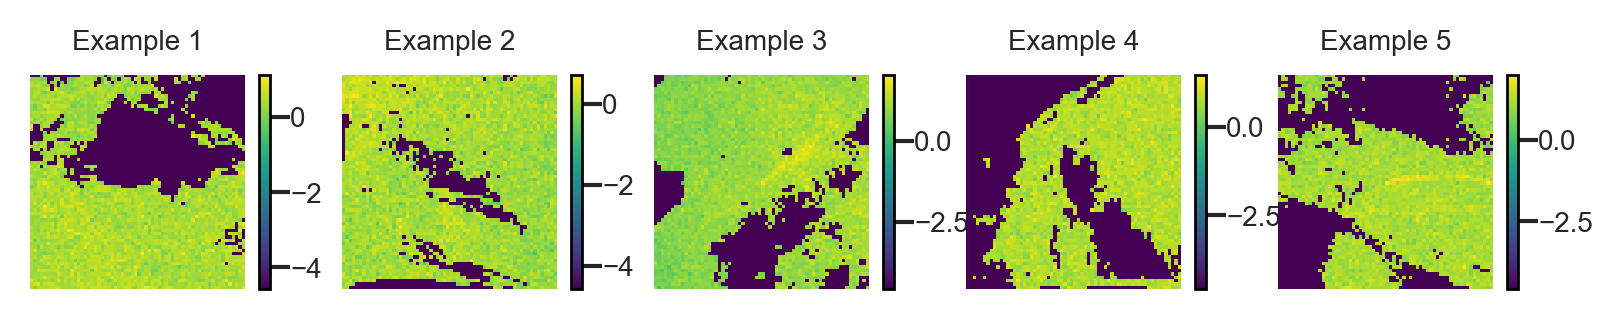

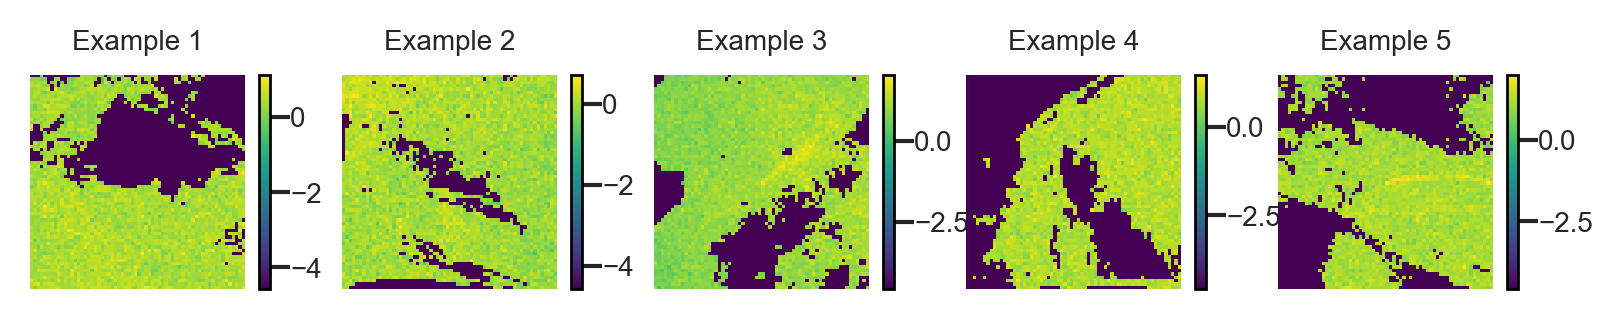

In [220]:
num_examples = 5
example_indices = np.random.choice(
    data.x.extra_valid.shape[0], num_examples, replace=False
)
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.extra_valid[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(
        data.x.extra_valid[idx, :, :, 0],
        cmap="viridis",
    )
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### Training on cloud model+cloud_layer, all samples pre-noised and pre-normalised

In [71]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

In [72]:
initiate_wb(cfg)

In [73]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)


In [74]:
model = model_trainer.model
data = model_trainer.data
mmap = np.load(data.x.path_clouds_array, mmap_mode="r")
clouds_training = np.array(mmap[: data.ds_train.N_img])
cloud_layer = model.get_layer("cloud_layer")
cloud_layer.clouds_array = clouds_training

In [116]:
cloud_core_model.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 cloud_layer (CloudsLayer)   (None, 64, 64, 4)         0         
                                                                 
 model_28 (Functional)       (None, 576)               186272    
                                                                 
 dense_6 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [75]:
cloud_core_model = tf.keras.models.Model(
    inputs=model.get_layer("cloud_layer").input, outputs=model.output
)
noise_norm_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("norm_layer").output
)
cloud_layer = model.get_layer("cloud_layer")

In [76]:
core_model.compile(
    optimizer=optimisers.define_optimiser(
        cfg.training.optimiser, cfg.training.learning_rate
    ),
    loss=loss.define_loss(cfg.model.loss_func),
)

In [77]:
num_samples = 10000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
noise_normed_collected_samples = noise_norm_layer(collected_samples, training=True)

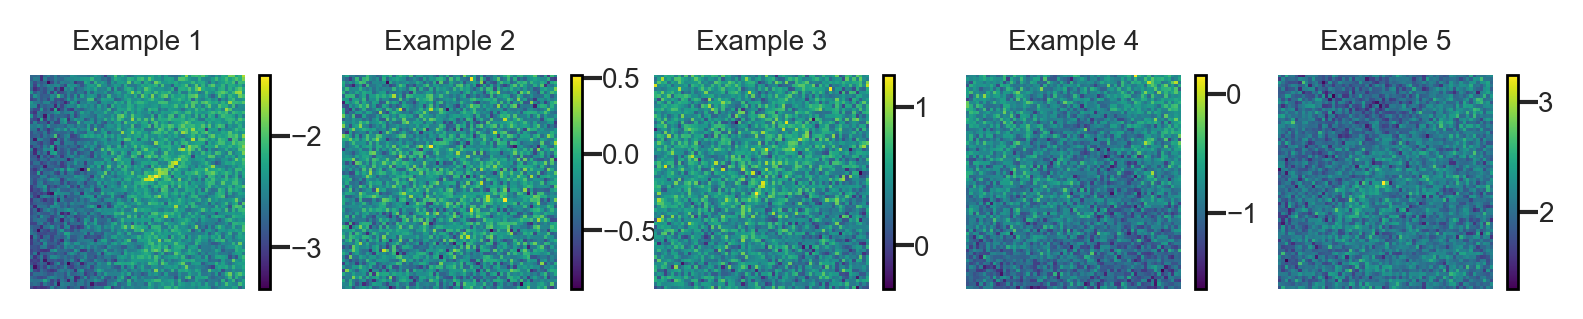

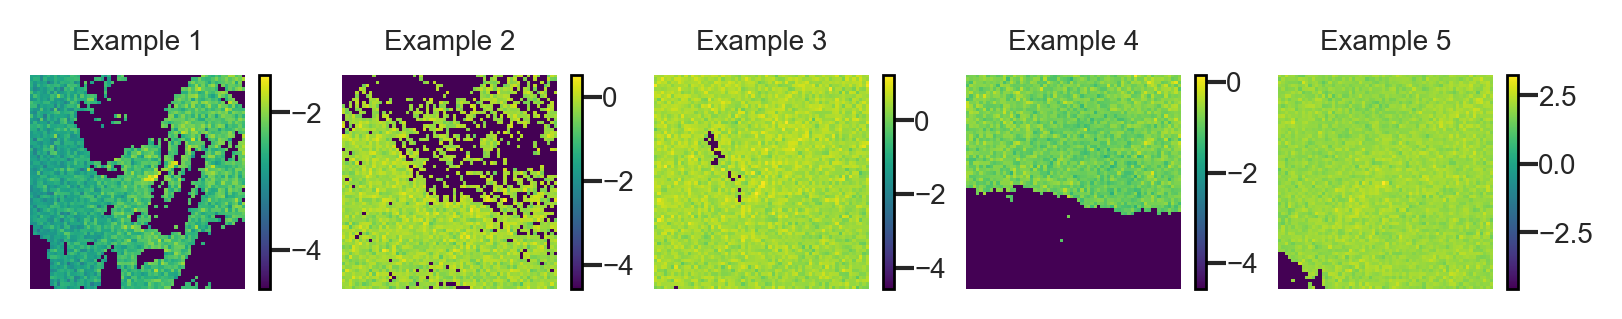

In [79]:
num_examples = 5
example_indices = np.random.choice(
    noise_normed_collected_samples.numpy().shape[0], num_examples, replace=False
)
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(noise_normed_collected_samples.numpy()[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(
        cloud_layer(noise_normed_collected_samples, training=True).numpy()[
            idx, :, :, 0
        ],
        cmap="viridis",
    )
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [88]:
coeur = .summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 cloud_layer (CloudsLayer)   (None, 64, 64, 4)         0         
                                                                 
 model_28 (Functional)       (None, 576)               186272    
                                                                 
 dense_6 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [104]:
def summarize_array(arr):
    ic(np.mean(arr), np.median(arr), np.min(arr), np.max(arr), np.std(arr), np.var(arr))

In [106]:
summarize_array(noise_normed_collected_samples.numpy())

ic| np.mean(arr): 0.01667469
    np.median(arr): -0.05010858
    np.min(arr): -47.208782
    np.max(arr): 112.79014
    np.std(arr): 1.0214272
    np.var(arr): 1.0433134


In [107]:
summarize_array(cloud_layer(noise_normed_collected_samples, training=True).numpy())

ic| np.mean(arr): -0.30266792
    np.median(arr): -0.16228133
    np.min(arr): -47.208782
    np.max(arr): 112.79014
    np.std(arr): 1.5057386
    np.var(arr): 2.2672489


In [111]:
coeur = tf.keras.models.Model(
    inputs=model.get_layer("cloud_layer").output, outputs=model.output
)

In [114]:
core_model.get_layer("model_28").input

<KerasTensor: shape=(None, 64, 64, 4) dtype=float32 (created by layer 'input_11')>

In [113]:
core_model.get_layer("cloud_layer").output

<KerasTensor: shape=(None, 64, 64, 4) dtype=float32 (created by layer 'cloud_layer')>

In [112]:
core_model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 cloud_layer (CloudsLayer)   (None, 64, 64, 4)         0         
                                                                 
 model_28 (Functional)       (None, 576)               186272    
                                                                 
 dense_6 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [124]:
core_model.fit(
    noise_normed_collected_samples,
    collected_outputs,
    epochs=1,
    validation_data=(
        cloud_layer(noise_normed_collected_samples, training=True),
        collected_outputs,
    ),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

768/786 [============================>.] - ETA: 0s - loss: 6.4547WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 786 batches). You may need to use the repeat() function when building your dataset.



Epoch 1: val_loss did not improve from 8.44197
extra_val_loss: 6.0142340660095215
786/786 [==============================] - 19s 25ms/step - loss: 6.4531 - val_loss: 9.7260 - lr: 0.0010


In [80]:
core_model.fit(
    noise_normed_collected_samples,
    collected_outputs,
    epochs=50,
    validation_data=(cloud_layer(noise_normed_collected_samples, training=True), collected_outputs),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=False,
)

Epoch 1/50
786/786 [==============================] - ETA: 0s - loss: 8.8135
Epoch 1: val_loss improved from inf to 9.22723, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 3.8278677463531494
786/786 [==============================] - 24s 29ms/step - loss: 8.8135 - val_loss: 9.2272 - lr: 0.0010
Epoch 2/50
786/786 [==============================] - ETA: 0s - loss: 8.4218
Epoch 2: val_loss improved from 9.22723 to 9.22129, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.299028396606445
786/786 [==============================] - 23s 30ms/step - loss: 8.4218 - val_loss: 9.2213 - lr: 0.0010
Epoch 3/50
785/786 [============================>.] - ETA: 0s - loss: 8.1920
Epoch 3: val_loss improved from 9.22129 to 9.08542, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.290931701660156
786/786 [==============================] - 23s 29ms/step - loss: 8.2002 - val_loss: 9.0854 - lr: 0.0010
Epoch 4/50
785/786 [============================>.] - ETA: 0s - loss: 8.1839
Epoch 4: val_loss did not improve from 9.08542
extra_val_loss: 4.83784818649292
786/786 [==============================] - 20s 26ms/step - loss: 8.1808 - val_loss: 9.6834 - lr: 0.0010
Epoch 5/50
784/786 [============================>.] - ETA: 0s - loss: 8.0648
Epoch 5: val_loss did not improve from 9.08542
extra_val_loss: 4.876646041870117
786/786 [==============================] - 20s 26ms/step - loss: 8.0582 - val_loss: 9.1559 - lr: 0.0010
Epoch 6/50
784/786 [============================>.] - ETA: 0s - loss: 7.9599
Epoch 6: val_loss improved from 9.08542 to 9.06975, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.967490196228027
786/786 [==============================] - 22s 28ms/step - loss: 7.9634 - val_loss: 9.0698 - lr: 0.0010
Epoch 7/50
786/786 [==============================] - ETA: 0s - loss: 7.9607
Epoch 7: val_loss did not improve from 9.06975
extra_val_loss: 4.798044681549072
786/786 [==============================] - 21s 26ms/step - loss: 7.9607 - val_loss: 9.3957 - lr: 0.0010
Epoch 8/50
784/786 [============================>.] - ETA: 0s - loss: 7.9275
Epoch 8: val_loss did not improve from 9.06975
extra_val_loss: 4.435779571533203
786/786 [==============================] - 20s 26ms/step - loss: 7.9309 - val_loss: 9.2460 - lr: 0.0010
Epoch 9/50
785/786 [============================>.] - ETA: 0s - loss: 7.7422
Epoch 9: val_loss improved from 9.06975 to 9.02709, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 5.185163497924805
786/786 [==============================] - 23s 29ms/step - loss: 7.7421 - val_loss: 9.0271 - lr: 0.0010
Epoch 10/50
784/786 [============================>.] - ETA: 0s - loss: 7.7812
Epoch 10: val_loss improved from 9.02709 to 8.64849, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.764084339141846
786/786 [==============================] - 23s 30ms/step - loss: 7.7804 - val_loss: 8.6485 - lr: 0.0010
Epoch 11/50
785/786 [============================>.] - ETA: 0s - loss: 7.7750
Epoch 11: val_loss did not improve from 8.64849
extra_val_loss: 5.419702529907227
786/786 [==============================] - 21s 26ms/step - loss: 7.7715 - val_loss: 9.0403 - lr: 0.0010
Epoch 12/50
786/786 [==============================] - ETA: 0s - loss: 7.6796
Epoch 12: val_loss did not improve from 8.64849
extra_val_loss: 6.998568534851074
786/786 [==============================] - 21s 26ms/step - loss: 7.6796 - val_loss: 9.6833 - lr: 0.0010
Epoch 13/50
784/786 [============================>.] - ETA: 0s - loss: 7.7137
Epoch 13: val_loss did not improve from 8.64849
extra_val_loss: 5.665200710296631
786/786 [==============================] - 21s 26ms/step - loss: 7.7063 - val_loss: 9.1024 - lr: 0.0010
Epoch 14/50
785/786 [============================>.] - ETA: 0s - loss:

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.834853172302246
786/786 [==============================] - 23s 30ms/step - loss: 7.1787 - val_loss: 8.4420 - lr: 0.0010
Epoch 26/50
785/786 [============================>.] - ETA: 0s - loss: 7.0764
Epoch 26: val_loss did not improve from 8.44197
extra_val_loss: 5.242734909057617
786/786 [==============================] - 21s 26ms/step - loss: 7.0766 - val_loss: 8.8589 - lr: 0.0010
Epoch 27/50
784/786 [============================>.] - ETA: 0s - loss: 7.1281
Epoch 27: val_loss did not improve from 8.44197
extra_val_loss: 6.573145866394043
786/786 [==============================] - 21s 26ms/step - loss: 7.1282 - val_loss: 9.9224 - lr: 0.0010
Epoch 28/50
786/786 [==============================] - ETA: 0s - loss: 6.9447
Epoch 28: val_loss did not improve from 8.44197
extra_val_loss: 6.519066333770752
786/786 [==============================] - 21s 26ms/step - loss: 6.9447 - val_loss: 9.6269 - lr: 0.0010
Epoch 29/50
786/786 [==============================] - ETA: 0s - loss:


KeyboardInterrupt



In [176]:
pred = tf.convert_to_tensor(
    core_model.predict(cloud_layer(noise_normed_collected_samples, training=True)),
    np.float32,
)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 6.2117915
mape: 64.980835


#### Replacement with explorable CloudsLayer

In [151]:
class CloudsLayer(tf.keras.layers.Layer):
    """Specific layer to add clouds to images only at training."""

    def __init__(
        self, clouds_array=[], cloudy_chans=[], nanmin=[], nanmedian=[], **kwargs
    ):
        super().__init__(**kwargs)
        self.clouds_array = clouds_array
        self.cloudy_chans = cloudy_chans
        self.eval_clouds_array = None
        self.nanmin = nanmin
        self.nanmedian = nanmedian

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "cloudy_chans": self.cloudy_chans,
                "nanmin": self.nanmin.numpy().tolist(),
                "nanmedian": self.nanmedian.numpy().tolist(),
            }
        )
        return config

    def evaluate_nanvalues(self, train_data):
        """Evaluate nan min and nan median values on train_data."""
        nanmin_np = np.nanmin(train_data, axis=(0, 1, 2))
        nanmedian_np = np.nanmedian(train_data, axis=(0, 1, 2))
        self.nanmin = tf.convert_to_tensor(nanmin_np, dtype=tf.float32)
        self.nanmedian = tf.convert_to_tensor(nanmedian_np, dtype=tf.float32)

    def call(self, inputs, training=None, **kwargs):
        # Assuming inputs and clouds_array are compatible for element-wise multiplication
        # Randomly select indices from clouds_array
        if training:
            random_indices = np.random.choice(
                self.clouds_array.shape[0], size=inputs.shape[0], replace=True
            )
            selected_clouds = self.clouds_array[random_indices]
            clouded_fields = self.apply_clouds_to_field(inputs, selected_clouds)

            self.random_indices = random_indices
            self.example_batch = clouded_fields
            return clouded_fields
        else:
            return inputs

    def apply_clouds_to_field(self, field, clouds):
        """Apply clouds to field given list_chans."""
        list_tensor = [None] * len(self.cloudy_chans)
        for idx, chan_name in enumerate(self.cloudy_chans):
            if chan_name in ["xco2", "no2"]:
                threshold = 0.01 if chan_name == "xco2" else 0.3
                bin_threshold = tf.cast(clouds < threshold, dtype=field.dtype)
                channel_data = field[:, :, :, idx]
                modified_channel_data = tf.where(
                    bin_threshold == 0,
                    tf.constant(np.nan, dtype=channel_data.dtype),
                    channel_data,
                )

                # Determine the appropriate numpy function based on chan_name
                nan_val = self.nanmin if chan_name == "xco2" else self.nanmedian

                # Apply the function and replace NaNs in the new tensor
                list_tensor[idx] = tf.where(
                    tf.math.is_nan(modified_channel_data),
                    tf.fill(
                        tf.shape(modified_channel_data),
                        nan_val[idx],
                    ),
                    modified_channel_data,
                )
            else:
                list_tensor[idx] = field[:, :, :, idx]
        new_field = tf.stack(list_tensor, axis=-1)
        return new_field

In [152]:
core_model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 cloud_layer (CloudsLayer)   (None, 64, 64, 4)         0         
                                                                 
 model_28 (Functional)       (None, 576)               186272    
                                                                 
 dense_6 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [188]:
# clouds_array=[], cloudy_chans=[], nanmin=[], nanmedian=[]
clouds_array = core_model.get_layer("cloud_layer").clouds_array
cloudy_chans = core_model.get_layer("cloud_layer").cloudy_chans
nanmin = core_model.get_layer("cloud_layer").nanmin
nanmedian = core_model.get_layer("cloud_layer").nanmedian
new_cloud_layer = CloudsLayer(
    clouds_array, cloudy_chans, nanmin, nanmedian, name="cloud_layer"
)
new_input = tf.keras.layers.Input(shape=[64, 64, 4])
x = new_cloud_layer(new_input)
for layer in core_model.layers[2:]:
    x = layer(x)
new_model = tf.keras.models.Model(inputs=new_input, outputs=x)

In [189]:
new_model.summary()

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 64, 64, 4)]       0         
                                                                 
 cloud_layer (CloudsLayer)   (None, 64, 64, 4)         0         
                                                                 
 model_28 (Functional)       (None, 576)               186272    
                                                                 
 dense_6 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186849 (729.88 KB)
Trainable params: 186657 (729.13 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


In [190]:
pred = tf.convert_to_tensor(
    new_model.predict(new_cloud_layer(noise_normed_collected_samples, training=True)),
    np.float32,
)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 5.983808
mape: 57.736607


In [191]:
new_model.compile(
    optimizer=optimisers.define_optimiser(
        cfg.training.optimiser, cfg.training.learning_rate
    ),
    loss=loss.define_loss(cfg.model.loss_func),
)

In [ ]:
new_model.fit(
    noise_normed_collected_samples,
    collected_outputs,
    epochs=100,
    validation_data=(
        cloud_layer(noise_normed_collected_samples, training=True),
        collected_outputs,
    ),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

Epoch 1/100
786/786 [==============================] - ETA: 0s - loss: 5.9487
Epoch 1: val_loss improved from 5.96233 to 5.90575, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.07505464553833
786/786 [==============================] - 21s 27ms/step - loss: 5.9487 - val_loss: 5.9058 - lr: 0.0010
Epoch 2/100
784/786 [============================>.] - ETA: 0s - loss: 5.8478
Epoch 2: val_loss improved from 5.90575 to 5.89663, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.683351039886475
786/786 [==============================] - 22s 27ms/step - loss: 5.8462 - val_loss: 5.8966 - lr: 0.0010
Epoch 3/100
784/786 [============================>.] - ETA: 0s - loss: 5.7670
Epoch 3: val_loss did not improve from 5.89663
extra_val_loss: 4.3372039794921875
786/786 [==============================] - 19s 24ms/step - loss: 5.7666 - val_loss: 5.9156 - lr: 0.0010
Epoch 4/100
784/786 [============================>.] - ETA: 0s - loss: 5.7187
Epoch 4: val_loss did not improve from 5.89663
extra_val_loss: 4.681266784667969
786/786 [==============================] - 19s 24ms/step - loss: 5.7157 - val_loss: 6.0547 - lr: 0.0010
Epoch 5/100
786/786 [==============================] - ETA: 0s - loss: 5.7147
Epoch 5: val_loss improved from 5.89663 to 5.83885, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_152940-23cjypq0/files/model-best)... Done. 0.1s


extra_val_loss: 4.574389457702637
786/786 [==============================] - 22s 28ms/step - loss: 5.7147 - val_loss: 5.8389 - lr: 0.0010
Epoch 6/100
785/786 [============================>.] - ETA: 0s - loss: 5.6401
Epoch 6: val_loss did not improve from 5.83885
extra_val_loss: 4.863905906677246
786/786 [==============================] - 20s 26ms/step - loss: 5.6379 - val_loss: 6.0944 - lr: 0.0010
Epoch 7/100
786/786 [==============================] - ETA: 0s - loss: 5.5596
Epoch 7: val_loss did not improve from 5.83885
extra_val_loss: 4.650356769561768
786/786 [==============================] - 21s 26ms/step - loss: 5.5596 - val_loss: 5.9523 - lr: 0.0010
Epoch 8/100
786/786 [==============================] - ETA: 0s - loss: 5.5894
Epoch 8: val_loss did not improve from 5.83885
extra_val_loss: 4.205780506134033
786/786 [==============================] - 21s 27ms/step - loss: 5.5894 - val_loss: 5.9716 - lr: 0.0010
Epoch 9/100
786/786 [==============================] - ETA: 0s - loss: 5.

KeyboardInterrupt: 

In [201]:
pred = tf.convert_to_tensor(
    new_model.predict(new_cloud_layer(noise_normed_collected_samples, training=True)),
    np.float32,
)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 6.2637444
mape: 72.928665


### with preproc_layer full and core_layer

In [53]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

In [54]:
initiate_wb(cfg)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▇▇▇▇▆▇▆▆▆▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▇▇▇▇▇▆▇▇▆▅▄▄▃▅▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁
extra_val_loss,▁▁▁▁▁▁▂▁▁▁▁▂▄▆▇█▃▅▄▃▄▃▄▆▃▄▄▃▃▃▃▄▃▃▅▄▅▃▂▄
loss,█▇▇▇▇▇▇▇▆▇▆▆▆▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▇▇▆▇▇▆▅▄▄▃▅▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁
best_epoch,48


In [55]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)


In [56]:
model = model_trainer.model
data = model_trainer.data
preproc_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("cloud_layer").output
)

mmap = np.load(data.x.path_clouds_array, mmap_mode="r")
clouds_training = np.array(mmap[: data.ds_train.N_img])
cloud_layer = preproc_layer.get_layer("cloud_layer")
cloud_layer.clouds_array = clouds_training

preproc_data_train = preproc_layer(data.x.train, training=True)

In [57]:
core_model = tf.keras.models.Model(inputs=model.input, outputs=model.output)
preproc_layer = tf.keras.models.Model(
    inputs=model.input, outputs=model.get_layer("cloud_layer").output
)

In [58]:
ic(preproc_layer.get_layer("cloud_layer").nanmin)

ic| preproc_layer.get_layer("cloud_layer").nanmin: <tf.Tensor: shape=(4,), dtype=float32, numpy=
                                                   array([  -4.5719457,   -4.2934794,   -2.7353425, -195.84026  ],
                                                         dtype=float32)>


<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([  -4.5719457,   -4.2934794,   -2.7353425, -195.84026  ],
      dtype=float32)>

In [59]:
core_model.compile(
    optimizer=optimisers.define_optimiser(
        cfg.training.optimiser, cfg.training.learning_rate
    ),
    loss=loss.define_loss(cfg.model.loss_func),
)

In [60]:
num_samples = 10000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in model_trainer.trainer.generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]
preproc_collected_samples = preproc_layer(collected_samples, training=True)

In [61]:
core_model.fit(
    collected_samples,
    collected_outputs,
    epochs=50,
    validation_data=(preproc_collected_samples, collected_outputs),
    verbose=1,
    steps_per_epoch=int(
        np.floor(data.x.train.shape[0] / model_trainer.trainer.batch_size)
    ),
    callbacks=model_trainer.trainer.callbacks,
    shuffle=True,
)

Epoch 1/50
785/786 [============================>.] - ETA: 0s - loss: 8.7024
Epoch 1: val_loss improved from inf to 8.22175, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 3.9999029636383057
786/786 [==============================] - 28s 33ms/step - loss: 8.7007 - val_loss: 8.2218 - lr: 0.0010
Epoch 2/50
784/786 [============================>.] - ETA: 0s - loss: 8.2600
Epoch 2: val_loss improved from 8.22175 to 7.98489, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.2744598388671875
786/786 [==============================] - 24s 30ms/step - loss: 8.2543 - val_loss: 7.9849 - lr: 0.0010
Epoch 3/50
784/786 [============================>.] - ETA: 0s - loss: 8.1484
Epoch 3: val_loss did not improve from 7.98489
extra_val_loss: 4.578676700592041
786/786 [==============================] - 21s 26ms/step - loss: 8.1470 - val_loss: 8.0996 - lr: 0.0010
Epoch 4/50
786/786 [==============================] - ETA: 0s - loss: 8.0674
Epoch 4: val_loss improved from 7.98489 to 7.95631, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.294525623321533
786/786 [==============================] - 23s 30ms/step - loss: 8.0674 - val_loss: 7.9563 - lr: 0.0010
Epoch 5/50
785/786 [============================>.] - ETA: 0s - loss: 7.9946
Epoch 5: val_loss did not improve from 7.95631
extra_val_loss: 4.2248005867004395
786/786 [==============================] - 21s 27ms/step - loss: 7.9983 - val_loss: 8.0893 - lr: 0.0010
Epoch 6/50
784/786 [============================>.] - ETA: 0s - loss: 7.8347
Epoch 6: val_loss improved from 7.95631 to 7.93021, saving model to w_best.h5


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.464200973510742
786/786 [==============================] - 23s 29ms/step - loss: 7.8327 - val_loss: 7.9302 - lr: 0.0010
Epoch 7/50
784/786 [============================>.] - ETA: 0s - loss: 7.9264
Epoch 7: val_loss did not improve from 7.93021
extra_val_loss: 4.163229465484619
786/786 [==============================] - 21s 27ms/step - loss: 7.9216 - val_loss: 8.2639 - lr: 0.0010
Epoch 8/50
784/786 [============================>.] - ETA: 0s - loss: 7.7818
Epoch 8: val_loss did not improve from 7.93021
extra_val_loss: 5.700824737548828
786/786 [==============================] - 21s 27ms/step - loss: 7.7838 - val_loss: 8.2363 - lr: 0.0010
Epoch 9/50
784/786 [============================>.] - ETA: 0s - loss: 7.5205
Epoch 9: val_loss did not improve from 7.93021
extra_val_loss: 5.289462089538574
786/786 [==============================] - 21s 27ms/step - loss: 7.5269 - val_loss: 8.9645 - lr: 0.0010
Epoch 10/50
786/786 [==============================] - ETA: 0s - loss: 7.268

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 5.141484260559082
786/786 [==============================] - 23s 29ms/step - loss: 7.2681 - val_loss: 7.8518 - lr: 0.0010
Epoch 11/50
784/786 [============================>.] - ETA: 0s - loss: 6.6155
Epoch 11: val_loss did not improve from 7.85176
extra_val_loss: 4.515483379364014
786/786 [==============================] - 21s 27ms/step - loss: 6.6143 - val_loss: 7.9828 - lr: 0.0010
Epoch 12/50
786/786 [==============================] - ETA: 0s - loss: 6.3980
Epoch 12: val_loss did not improve from 7.85176
extra_val_loss: 7.626372337341309
786/786 [==============================] - 21s 26ms/step - loss: 6.3980 - val_loss: 9.0646 - lr: 0.0010
Epoch 13/50
786/786 [==============================] - ETA: 0s - loss: 6.2031
Epoch 13: val_loss did not improve from 7.85176
extra_val_loss: 5.810160160064697
786/786 [==============================] - 21s 27ms/step - loss: 6.2031 - val_loss: 8.4159 - lr: 0.0010
Epoch 14/50
784/786 [============================>.] - ETA: 0s - loss:

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.032979965209961
786/786 [==============================] - 21s 27ms/step - loss: 5.0920 - val_loss: 7.6133 - lr: 0.0010
Epoch 31/50
784/786 [============================>.] - ETA: 0s - loss: 5.0211
Epoch 31: val_loss did not improve from 7.61328
extra_val_loss: 6.217512130737305
786/786 [==============================] - 19s 24ms/step - loss: 5.0178 - val_loss: 8.4679 - lr: 0.0010
Epoch 32/50
785/786 [============================>.] - ETA: 0s - loss: 5.0287
Epoch 32: val_loss did not improve from 7.61328
extra_val_loss: 6.873380184173584
786/786 [==============================] - 19s 24ms/step - loss: 5.0305 - val_loss: 8.3494 - lr: 0.0010
Epoch 33/50
784/786 [============================>.] - ETA: 0s - loss: 4.9478
Epoch 33: val_loss did not improve from 7.61328
extra_val_loss: 7.248407363891602
786/786 [==============================] - 20s 25ms/step - loss: 4.9466 - val_loss: 9.0448 - lr: 0.0010
Epoch 34/50
784/786 [============================>.] - ETA: 0s - loss:

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.4456353187561035
786/786 [==============================] - 21s 27ms/step - loss: 4.8362 - val_loss: 7.4626 - lr: 0.0010
Epoch 38/50
785/786 [============================>.] - ETA: 0s - loss: 4.9289
Epoch 38: val_loss did not improve from 7.46264
extra_val_loss: 5.5283050537109375
786/786 [==============================] - 19s 24ms/step - loss: 4.9281 - val_loss: 7.8646 - lr: 0.0010
Epoch 39/50
784/786 [============================>.] - ETA: 0s - loss: 4.8042
Epoch 39: val_loss did not improve from 7.46264
extra_val_loss: 4.59018087387085
786/786 [==============================] - 19s 24ms/step - loss: 4.7989 - val_loss: 7.6568 - lr: 0.0010
Epoch 40/50
786/786 [==============================] - ETA: 0s - loss: 4.9379
Epoch 40: val_loss did not improve from 7.46264
extra_val_loss: 6.568582534790039
786/786 [==============================] - 19s 24ms/step - loss: 4.9379 - val_loss: 8.1960 - lr: 0.0010
Epoch 41/50
786/786 [==============================] - ETA: 0s - loss

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.862131595611572
786/786 [==============================] - 21s 27ms/step - loss: 4.7567 - val_loss: 7.4404 - lr: 0.0010
Epoch 42/50
785/786 [============================>.] - ETA: 0s - loss: 4.7390
Epoch 42: val_loss did not improve from 7.44036
extra_val_loss: 5.364397048950195
786/786 [==============================] - 19s 24ms/step - loss: 4.7364 - val_loss: 8.0029 - lr: 0.0010
Epoch 43/50
784/786 [============================>.] - ETA: 0s - loss: 4.7101
Epoch 43: val_loss did not improve from 7.44036
extra_val_loss: 5.299342632293701
786/786 [==============================] - 19s 24ms/step - loss: 4.7086 - val_loss: 7.5426 - lr: 0.0010
Epoch 44/50
785/786 [============================>.] - ETA: 0s - loss: 4.7234
Epoch 44: val_loss did not improve from 7.44036
extra_val_loss: 5.438530921936035
786/786 [==============================] - 19s 24ms/step - loss: 4.7219 - val_loss: 7.8357 - lr: 0.0010
Epoch 45/50
784/786 [============================>.] - ETA: 0s - loss:

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets


INFO:tensorflow:Assets written to: /cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best/assets
wandb: Adding directory to artifact (/cerea_raid/users/dumontj/dev/coco2/inv/wandb/run-20231211_135402-22tz0yh3/files/model-best)... Done. 0.1s


extra_val_loss: 4.510923385620117
786/786 [==============================] - 22s 28ms/step - loss: 4.7260 - val_loss: 7.3601 - lr: 0.0010
Epoch 46/50
785/786 [============================>.] - ETA: 0s - loss: 4.6911
Epoch 46: val_loss did not improve from 7.36015
extra_val_loss: 5.480877876281738
786/786 [==============================] - 19s 24ms/step - loss: 4.6938 - val_loss: 7.4750 - lr: 0.0010
Epoch 47/50
784/786 [============================>.] - ETA: 0s - loss: 4.6659
Epoch 47: val_loss did not improve from 7.36015
extra_val_loss: 4.618609428405762
786/786 [==============================] - 20s 25ms/step - loss: 4.6634 - val_loss: 7.5683 - lr: 0.0010
Epoch 48/50
784/786 [============================>.] - ETA: 0s - loss: 4.6928
Epoch 48: val_loss did not improve from 7.36015
extra_val_loss: 4.702386856079102
786/786 [==============================] - 20s 25ms/step - loss: 4.6933 - val_loss: 7.5141 - lr: 0.0010
Epoch 49/50
771/786 [============================>.] - ETA: 0s - loss:


Epoch 49: val_loss did not improve from 7.36015
extra_val_loss: 4.81767463684082
786/786 [==============================] - 19s 24ms/step - loss: 4.6677 - val_loss: 7.6202 - lr: 0.0010


In [62]:
pred = tf.convert_to_tensor(new_model.predict(preproc_collected_samples), np.float32)
y = tf.convert_to_tensor(collected_outputs, np.float32)
metrics = model_eval.get_inv_metrics(y, pred)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

313/313 [==============================] - 3s 9ms/step
mae: 7.6202326
mape: 61.958
